In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2
import tensorflow as tf
from tqdm import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
from imgaug import parameters as iap
import time

seed = None
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
sartorius_df = pd.read_csv('../sartorius-cell-instance-segmentation/train.csv')

HEIGHT = 520
WIDTH = 704
SHAPE = (HEIGHT, WIDTH)

In [36]:
def make_mask(image_id, SHAPE=(520, 704)):
    rows = sartorius_df.loc[sartorius_df['id'] == image_id]
    
    # Image shape
    mask = np.full(shape=[len(rows), np.prod(SHAPE)], fill_value=0, dtype=np.uint8)
    
    for idx, (_, row) in enumerate(rows.iterrows()):
        s = row['annotation'].split()
        starts, lengths = [np.array(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            mask[idx, lo:hi] = True
        
    mask = mask.reshape([len(rows), *SHAPE])
    mask = np.moveaxis(mask, 0, 2)
    
    return mask

# Run Length Encode an instance
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    #img = unpad_image(img)
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def plot_image_and_mask(img, mask):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    
    axs[0].imshow(img, cmap='gray')
    axs[0].set_xlabel('Input before augmenting', fontsize=13)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    
    axs[1].imshow(np.sum(mask, -1), cmap='seismic')
    axs[1].set_xlabel('Ground truth before augmenting', fontsize=13)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    plt.tight_layout()

get_image_path = lambda image_id: '{}.{}'.format(os.path.join('../sartorius-cell-instance-segmentation/train', image_id), 'png')

In [22]:
aug_seq = iaa.Sequential([
    iaa.Crop(percent=ia.random.uniform(0.05, 0.1)),
    iaa.Fliplr(0.65),
    iaa.Flipud(0.65),
    iaa.Affine(rotate=ia.random.uniform(5, 15))
    #iaa.AdditiveGaussianNoise(scale=(10, 25))
])

In [32]:
img_id = np.random.choice(sartorius_df['id'], 1)[0]

In [33]:
img = io.imread(get_image_path(img_id))
mask = make_mask(img_id)

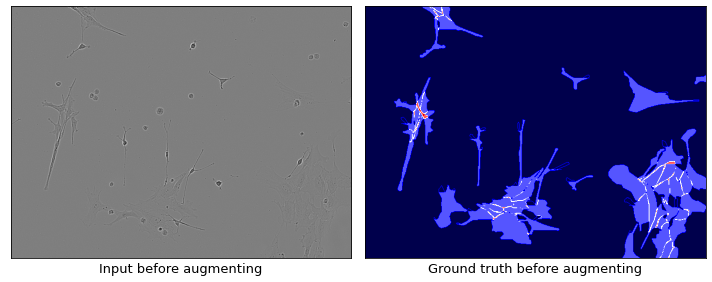

In [37]:
plot_image_and_mask(img, mask)

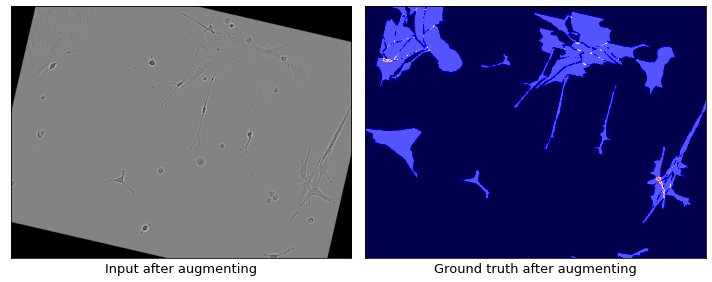

In [35]:
aug_det = aug_seq.to_deterministic()

img_aug_1 = aug_det.augment_image(img)
mask_aug_1 = aug_det.augment_image(mask)

plot_image_and_mask(img_aug_1, mask_aug_1)

In [9]:
img_aug_1.shape

(520, 704)

In [10]:
mask.shape

(520, 704, 176)

In [11]:
x = np.dstack([mask[..., i] * img_aug_1 for i in range(mask.shape[-1])])

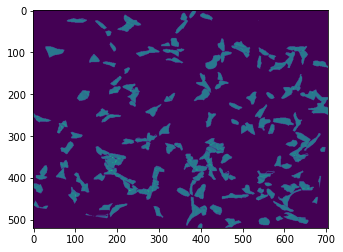

In [12]:
plt.imshow(np.sum(x, -1))

TypeError: Invalid shape (520, 704, 176) for image data

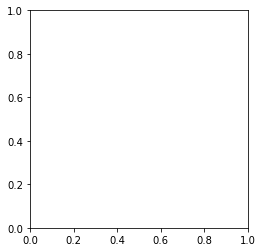

In [13]:
plt.imshow(mask)

In [ ]:
mask.max()

In [ ]:
merged = cv2.addWeighted(img_aug_1, 0.75, np.clip(np.sum(mask_aug_1, -1).astype(img_aug_1.dtype), 0, 1)*255, 0.25, 0.0,)
plt.imshow(merged, cmap='gray')

In [ ]:
unique_images = sartorius_df['id'].unique()

In [ ]:
nrows, ncols = 2, 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 8))

image_ids = np.random.choice(unique_images, nrows*ncols)

for i in range(nrows):
    for j in range(ncols):
        image_id = image_ids[i * 1 + j]
        mask = make_mask(image_id)
        image = io.imread('../sartorius-cell-instance-segmentation/train/' + image_id + '.png')
        axs[i, j].imshow(np.sum(mask, -1), cmap='gray')
        #axs[i, j].imshow(image, cmap='gray')
        #merged = cv2.addWeighted(image, 0.75, 
        #                         np.clip(np.sum(mask, -1).astype(image.dtype), 0, 1)*255, 0.25, 0.0,)
        #axs[i, j].imshow(merged, cmap='gray')
        axs[i, j].set_xlabel(image_id, fontsize=15)
        axs[i, j].set_xticks(ticks=[])
        axs[i, j].set_yticks(ticks=[])

plt.tight_layout()
plt.show()

In [ ]:
image_ids